<a href="https://colab.research.google.com/github/AFBA1993/Projects/blob/main/TemporalSeries/PAGS/PAGSlstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
path = "/content/drive/MyDrive/DatasetsTemporalSeries/PAGSattempt.csv"
data = pd.read_csv(path)
data.tail() 

,Date,Open,High,Low,Close,Adj Close,Volume
1038,2022-03-09,13.01,13.73,13.01,13.44,13.44,2140900
1039,2022-03-10,13.09,13.16,12.61,12.95,12.95,1971400
1040,2022-03-11,13.29,13.65,12.55,12.61,12.61,2065300
1041,2022-03-14,12.40,12.87,11.76,11.90,11.90,1795300
1042,2022-03-15,11.85,12.61,11.85,12.51,12.51,2470450


In [32]:
data = data[["Date","Close"]]

In [33]:
data.index = pd.to_datetime(data["Date"])
data.drop("Date", axis = 1, inplace =  True)


In [39]:
data.tail()

,Close
Date,
2022-03-09,13.44
2022-03-10,12.95
2022-03-11,12.61
2022-03-14,11.90
2022-03-15,12.51


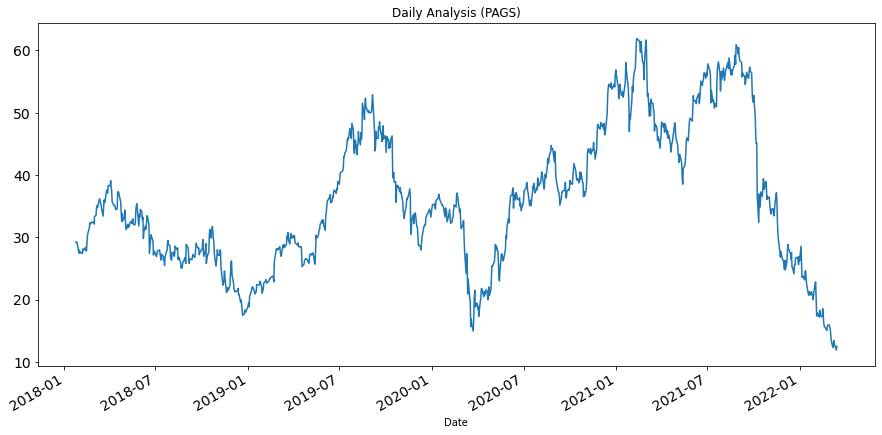

In [37]:
data.Close.plot(figsize = (15,7), title = 'Daily Analysis (PAGS)', fontsize =14, 
                                                              label = 'Train')

In [40]:
train = data.loc['2018-01-24' : '2021-07-01'].copy()
test = data.loc['2021-07-02' : '2022-03-15'].copy()

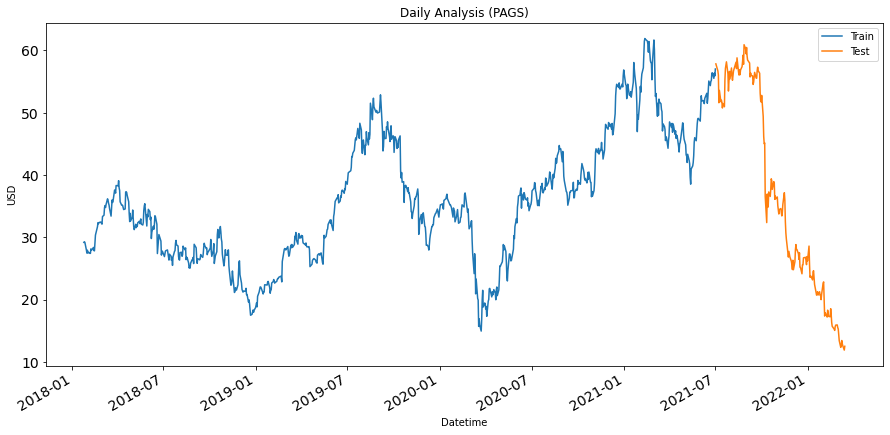

In [45]:
train.Close.plot(figsize = (15,7), label = 'Train')
test.Close.plot(figsize = (15,7), title = 'Daily Analysis (PAGS)', fontsize =14, 
                                                          label = 'Test')
plt.xlabel('Datetime')
plt.ylabel('USD')
plt.legend(loc = 'best')

In [46]:
normalizer = MinMaxScaler(feature_range = (0,1))
train_norm = normalizer.fit_transform(train)

In [47]:
forecasters_train = []
actual_value_train = []

In [48]:
train.size

866

In [49]:
for i in range(100, 866):
  forecasters_train.append(train_norm[i-100:i,0])
  actual_value_train.append(train_norm[i, 0])

In [50]:
forecasters_train , actual_value_train = np.array(forecasters_train), \
                                         np.array(actual_value_train)

In [51]:
print(forecasters_train.shape[0],
      forecasters_train.shape[1])

766 100


In [52]:
forecasters_train = np.reshape(forecasters_train, (766, 100, 1))

In [53]:
regressor = Sequential()
regressor.add(LSTM(units = 150, return_sequences = True,
                   input_shape = (forecasters_train.shape[1], 1)))
regressor.add(Dropout(0.3))

In [54]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

In [55]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

In [56]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.3))

In [57]:
regressor.add(Dense(units = 1, activation = 'linear'))

In [58]:

regressor.compile(optimizer = 'rmsprop', loss = 'mse',
                  metrics = ['mse'])

In [59]:
regressor.fit(forecasters_train, actual_value_train, 
                      epochs = 100, batch_size = 32)

Epoch 1/100
24/24 [==============================] - 14s 273ms/step - loss: 0.0776 - mse: 0.0776
Epoch 2/100
24/24 [==============================] - 6s 264ms/step - loss: 0.0235 - mse: 0.0235
Epoch 3/100
24/24 [==============================] - 7s 276ms/step - loss: 0.0224 - mse: 0.0224
Epoch 4/100
24/24 [==============================] - 7s 271ms/step - loss: 0.0176 - mse: 0.0176
Epoch 5/100
24/24 [==============================] - 7s 277ms/step - loss: 0.0199 - mse: 0.0199
Epoch 6/100
24/24 [==============================] - 7s 296ms/step - loss: 0.0142 - mse: 0.0142
Epoch 7/100
24/24 [==============================] - 8s 324ms/step - loss: 0.0128 - mse: 0.0128
Epoch 8/100
24/24 [==============================] - 6s 268ms/step - loss: 0.0111 - mse: 0.0111
Epoch 9/100
24/24 [==============================] - 7s 275ms/step - loss: 0.0121 - mse: 0.0121
Epoch 10/100
24/24 [==============================] - 8s 320ms/step - loss: 0.0106 - mse: 0.0106
Epoch 11/100
24/24 [==================

In [60]:
complete_data = pd.concat((train, test), axis = 0)
input_test = complete_data[len(complete_data) - len(test) - 100:]
input_test_norm = normalizer.transform(input_test)

In [61]:
input_test_norm.shape

(277, 1)

In [63]:
X_test = []
for i in range(100, 277):
  X_test.append(input_test_norm[i-100:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))

In [64]:
predicted_test = regressor.predict(X_test)
predicted_test = normalizer.inverse_transform(predicted_test)
len(predicted_test)

177

In [65]:
forecasted_LSTM = pd.DataFrame(predicted_test, columns = ['Close'])

In [66]:
forecasted_LSTM["Date"] = test.index

In [67]:
forecasted_LSTM

,Close,Date
0,56.565132,2021-07-02
1,57.339504,2021-07-06
2,56.446835,2021-07-07
3,55.794823,2021-07-08
4,52.518349,2021-07-09
...,...,...
172,14.740492,2022-03-09
173,15.231791,2022-03-10
174,15.339025,2022-03-11
175,15.040317,2022-03-14


In [69]:
forecasted_LSTM.index = pd.to_datetime(forecasted_LSTM["Date"])
forecasted_LSTM.drop("Date", axis = 1, inplace =  True)
forecasted_LSTM.tail()

,Close
Date,
2022-03-09,14.740492
2022-03-10,15.231791
2022-03-11,15.339025
2022-03-14,15.040317
2022-03-15,14.506045


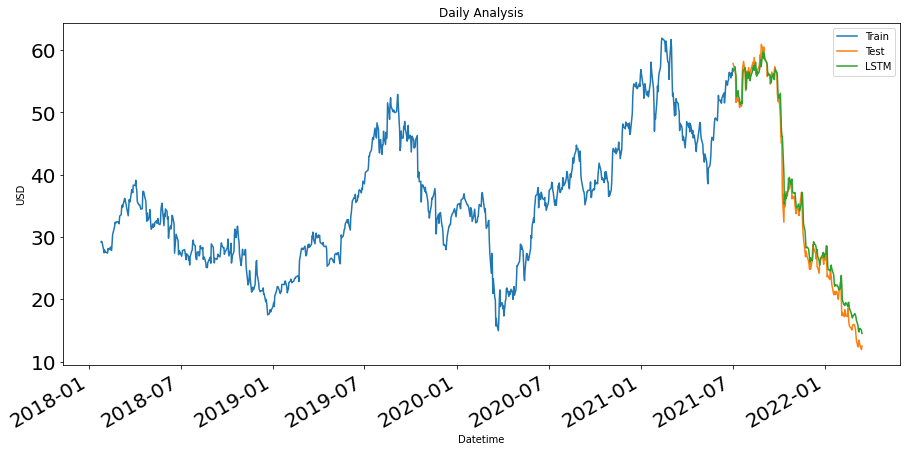

In [70]:
train.Close.plot(figsize = (15,7), title = 'Daily Analysis', fontsize = 20, 
                                                             label = 'Train')
test.Close.plot(figsize = (15,7), title = 'Daily Analysis', fontsize =  20, 
                                                          label = 'Test')
forecasted_LSTM.Close.plot(figsize = (15,7), title = 'Daily Analysis', 
                                                             fontsize =  20, 
                                                              label = 'LSTM')
plt.xlabel('Datetime')
plt.ylabel('USD')
plt.legend(loc = 'best')